## A RESEARCH PROJECT ON

# RAIN PREDICTION ANALYSIS FOR SAGAMU METROPOLIS¶

### INTRODUCTION

Weather has a great influence on human activities, that can be positive or negative. It affects all sphere of human endeavour from food, shelter, clothing, outings, health etc. Weather prediction or forecast is a product of science that impacts the lives of many people and is essential in protecting lives and properties. It is very useful in planning outdoor activities, dressing, where to go. In the business sector, plans are made on transportation hazards, production and other activities that are influenced by environmental hazards.

Forecasts based on temperature and rainfall are very important in agriculture for crop planning calendar (the type of crop to grow, where and when to grow, irrigation) and disease forcast for crops and animals. It is also useful for governments to make necessary preparations in case of natural disaster and provide support for economic prosperity and improvement of quality of life of the people.

Sagamu is a city in Southwest Nigeria, West Africa located on Coordinates: 6°50′N 3°39′E. It is a conglomeration of thirteen towns along the Lagos - Ibadan corridor. It is surrounded by many villages which are agrarian. The city houses industrial hubs in Ogun State and the inhabitants are predominantly industry workers, traders and farmers. The weather is tropical rainforest having rainfall for all the months of the year, with peak in June/July. Accurate weather information will be useful for the inhabitiants as well as travelers in Sagamu and environs.

This Project aims to provide accurate rainfall prediction for Sagamu area of Ogun State.

### DATA SOURCING
Weather data was sourced from the Data Management Unit (DMU) of Nigerian Meteorological Agency (NiMet). Daily data for 15 years (2006 to 2020) was obtained. The following weather parameters were collected:

- Rainfall (mm)
- Maximum Temperature (degrees celcius)
- Minimum Temperature (degrees celcius)
- Relative Humidity (%)
- Wind Speed (Knot)
- Wind Direction (Degree)

### IMPORTING THE REQUIRED LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

import warnings
warnings.filterwarnings('ignore')


from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import zscore
from scipy.stats import skew

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score


# from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

In [2]:
df = pd.read_csv("data/project_data.csv")

In [3]:
df.head()

,date,rainfall,max_temp,min_temp,rel_humidity,wind_speed,wind _direction
0,1/1/2006,0.0,35.0,25.0,71,0,180
1,1/2/2006,0.0,35.0,25.0,64,6,270
2,1/3/2006,0.0,35.0,25.0,68,5,220
3,1/4/2006,0.0,35.0,25.0,76,12,220
4,1/5/2006,0.0,34.0,23.0,71,5,290


In [4]:
df.columns

Index(['date', 'rainfall', 'max_temp', 'min_temp', 'rel_humidity',
       'wind_speed', 'wind _direction'],
      dtype='object')

In [5]:
# Renaming the wind_direction columns for better readability
df = df.rename(columns={'wind _direction': 'wind_direction'})

###### Let's categorize the rainfall level by defining the thresholds for classifying the rainfall levels and creating a new column called the rainfall_level and visualize the output in a count plot

In [6]:
df['average_temp'] = (df['max_temp'] + df['min_temp']) / 2

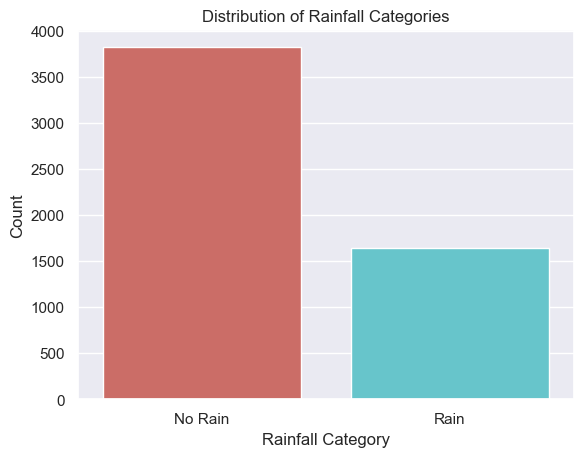

In [7]:
df['rainfall_level'] = np.where(df['rainfall'] == 0.0, 'No Rain', 'Rain')

df_selected = df[df['rainfall_level'].isin(['No Rain', 'Rain'])]

sns.set(style="darkgrid")
sns.countplot(data=df_selected, x='rainfall_level', palette ='hls')
plt.xlabel('Rainfall Category')
plt.ylabel('Count')
plt.title('Distribution of Rainfall Categories')
plt.show()

It was observed that "No Rain" has the highest value from the visualization and to gain more insight into this, the percentage is calculated thus:

In [8]:
total_count = len(df)
no_rain_count = df['rainfall_level'].value_counts()['No Rain']
rain_count = df['rainfall_level'].value_counts()['Rain']

no_rain_percentage = (no_rain_count / total_count) * 100
rain_percentage = (rain_count / total_count) * 100

print('No Rain Percentage:', no_rain_percentage)
print('Rain Percentage:', rain_percentage)

No Rain Percentage: 69.95055850576819
Rain Percentage: 30.049441494231825


From the calculation above we get to see that the percentage of No Rain is higher in our dataset so let's explore more on this.

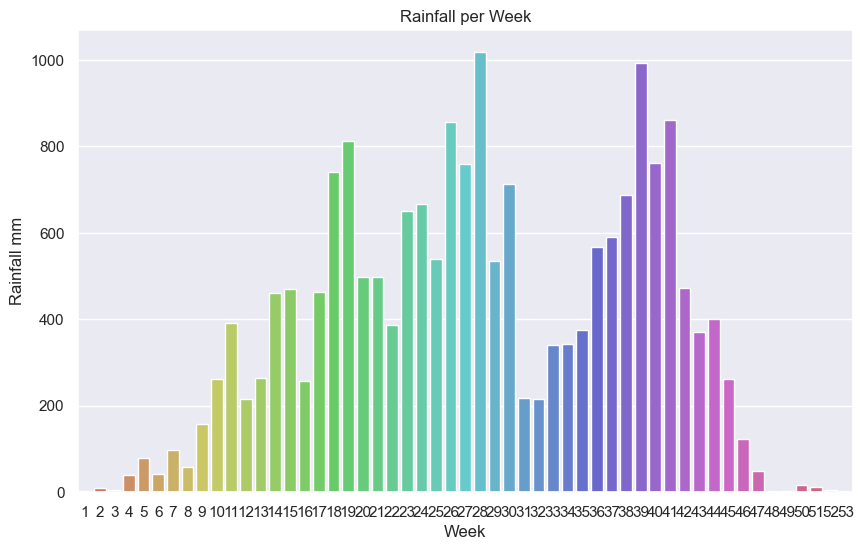

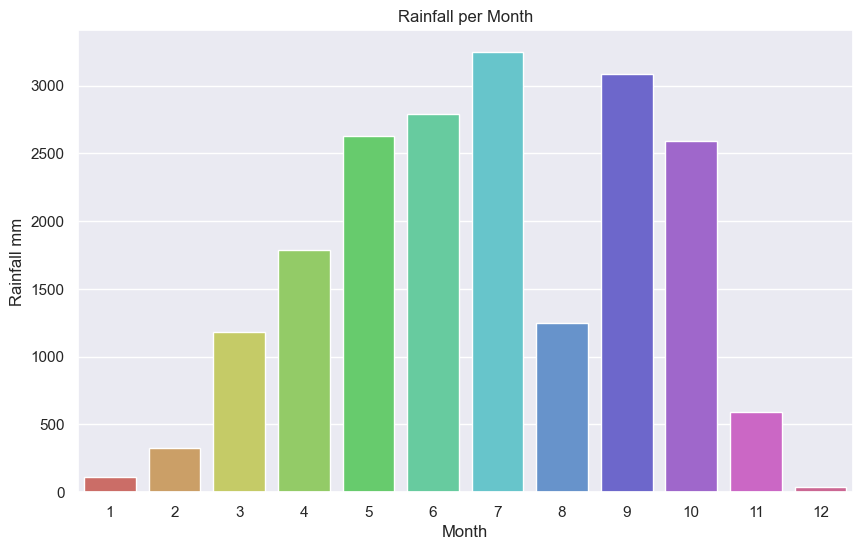

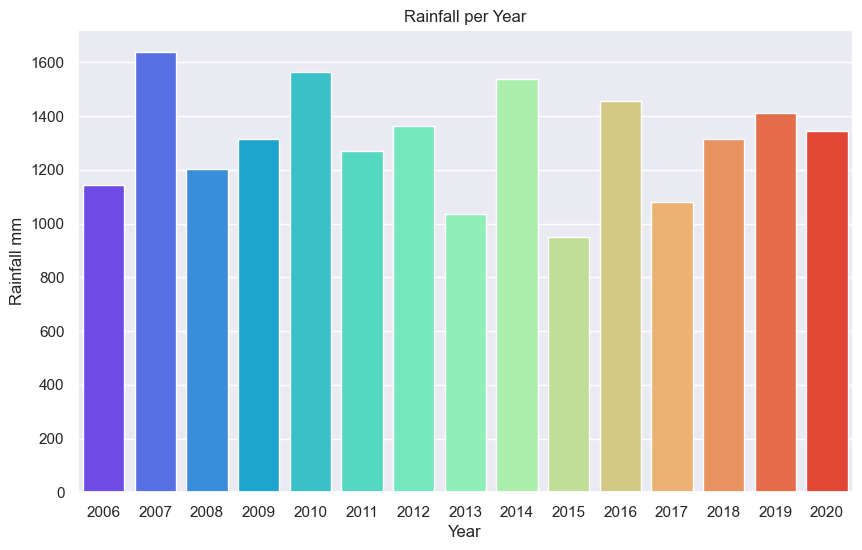

In [9]:
df['date'] = pd.to_datetime(df['date'])

weekly = df.groupby(df['date'].dt.week)['rainfall'].sum()

# Plot the rainfall per week
plt.figure(figsize=(10, 6))
sns.barplot(x=weekly.index, y=weekly.values, palette='hls')
plt.xlabel('Week')
plt.ylabel('Rainfall mm')
plt.title('Rainfall per Week')
plt.show()

monthly = df.groupby(df['date'].dt.month)['rainfall'].sum()

# Plot the rainfall per month
plt.figure(figsize=(10, 6))
sns.barplot(x=monthly.index, y=monthly.values, palette='hls')
plt.xlabel('Month')
plt.ylabel('Rainfall mm')
plt.title('Rainfall per Month')
plt.show()

yearly = df.groupby(df['date'].dt.year)['rainfall'].sum()

# Plot the rainfall per year
plt.figure(figsize=(10, 6))
sns.barplot(x=yearly.index, y=yearly.values, palette='rainbow')
plt.xlabel('Year')
plt.ylabel('Rainfall mm')
plt.title('Rainfall per Year')
plt.show()


The graphs show rainfall pattern per week, per month and per year. It was observed that in the study area (Sagamu), rainfall was recorded in all the months of the year. There was an increase from January to July and a sharp drop in August (break). Peaks were recorded for the months of July and September, then a steady decline to December.

The graph of annual rainfall revealed a high rainfall pattern for most of the 15 years studied. The lowest amount of rain was recorded in Year 2015 (about 900mm) and the highest (over 1600mm) in Year 2007.

### Creating a temperature range

By claculating and analyzing the temperature range, additional insights can be gained into the temperature patterns and variability.

In [10]:
df['temp_range'] = np.abs(df['max_temp'] - df['min_temp'])

In [11]:
df.temp_range

0       10.0
1       10.0
2       10.0
3       10.0
4       11.0
        ... 
5456    12.2
5457    18.4
5458    17.5
5459    14.9
5460    16.0
Name: temp_range, Length: 5461, dtype: float64

The result from the temperature range provided an indication of the variability in temperature throughout the day, reflecting the difference between the warmest and coolest parts of the day.

### Calculating the Temperature and Relative Humidity Interaction

By considering the combined effects of temperature and humidity, it is possible

- to gain insights into weather patterns,
- assess thermal comfort conditions,
- predict precipitation events,
- and evaluate the impact of climate change on different ecosystems and human activities

In [12]:
df['temp_humidity_interaction'] = df['max_temp'] * df['rel_humidity']

Let's check the numeric columns in our dataset

In [13]:
df.columns

Index(['date', 'rainfall', 'max_temp', 'min_temp', 'rel_humidity',
       'wind_speed', 'wind_direction', 'average_temp', 'rainfall_level',
       'temp_range', 'temp_humidity_interaction'],
      dtype='object')

In [14]:
df.dtypes

date                         datetime64[ns]
rainfall                            float64
max_temp                            float64
min_temp                            float64
rel_humidity                          int64
wind_speed                            int64
wind_direction                        int64
average_temp                        float64
rainfall_level                       object
temp_range                          float64
temp_humidity_interaction           float64
dtype: object

In [15]:
df.describe()

,rainfall,max_temp,min_temp,rel_humidity,wind_speed,wind_direction,average_temp,temp_range,temp_humidity_interaction
count,5461.000000,5461.000000,5461.000000,5461.000000,5461.000000,5461.000000,5461.000000,5461.000000,5461.000000
mean,3.593225,33.204111,23.670255,78.215528,3.236587,126.525728,28.437183,9.534113,2581.787209
std,10.740023,2.813193,1.861024,15.005843,2.548947,105.438962,1.831633,3.054589,474.606820
min,0.000000,24.200000,2.380000,19.000000,0.000000,0.000000,18.290000,0.000000,693.500000
25%,0.000000,31.000000,22.800000,73.000000,1.000000,0.000000,27.050000,7.500000,2450.000000
50%,0.000000,33.400000,23.900000,80.000000,3.000000,150.000000,28.500000,9.500000,2624.000000
75%,0.600000,35.400000,24.900000,85.000000,5.000000,210.000000,29.800000,11.300000,2766.400000
max,134.200000,41.000000,32.000000,887.000000,18.000000,361.000000,33.800000,31.820000,29625.800000


Let's create an histogram on the numeric columns with the estimated probability density function of the data

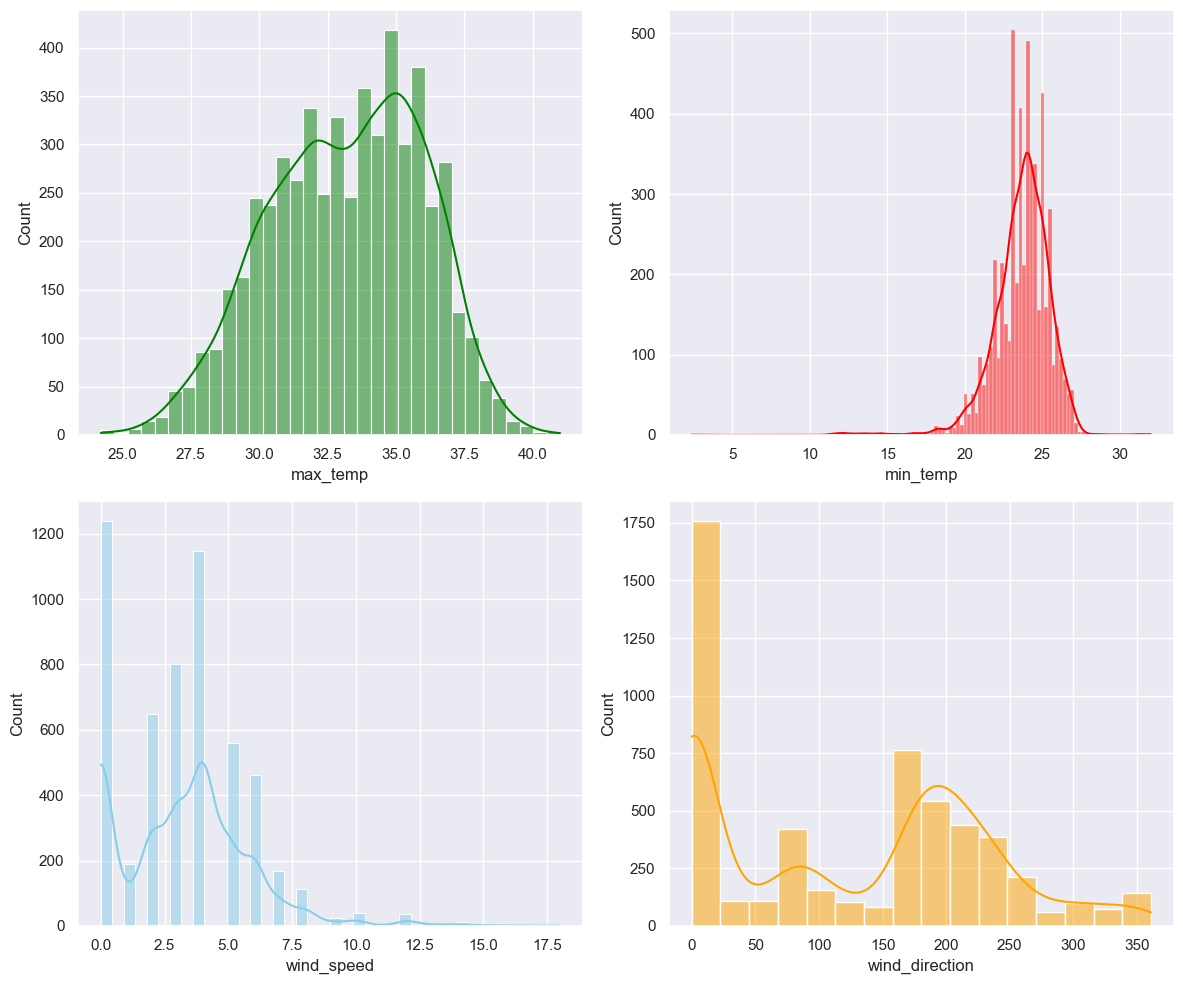

In [16]:
fig_width = 12
fig_height = 10

fig = plt.figure(figsize=(fig_width, fig_height))

axs = fig.subplots(2, 2)
sns.histplot(data=df, x="max_temp", kde=True, ax=axs[0, 0], color='green')
sns.histplot(data=df, x="min_temp", kde=True, ax=axs[0, 1], color='red')
sns.histplot(data=df, x="wind_speed", kde=True, ax=axs[1, 0], color='skyblue')
sns.histplot(data=df, x="wind_direction", kde=True, ax=axs[1, 1], color='orange')

plt.tight_layout()
plt.show()



The chart displays the distribution of four variables: maximum temperature (max_temp), minimum temperature (min_temp), wind speed, and wind direction. Each histogram with a KDE curve represents the frequency of values for each variable. The x-axis represents the respective variable values, and the y-axis represents the count or density of occurrences.

In [17]:
df.corr()

,rainfall,max_temp,min_temp,rel_humidity,wind_speed,wind_direction,average_temp,temp_range,temp_humidity_interaction
rainfall,1.000000,-0.146404,-0.061711,0.128232,-0.023565,-0.010968,-0.143781,-0.097110,0.068262
max_temp,-0.146404,1.000000,0.195024,-0.362263,0.094348,0.112221,0.867023,0.801894,0.084428
min_temp,-0.061711,0.195024,1.000000,0.021584,0.000265,-0.097382,0.657791,-0.429575,0.120928
rel_humidity,0.128232,-0.362263,0.021584,1.000000,-0.034632,-0.059878,-0.267233,-0.346830,0.897000
wind_speed,-0.023565,0.094348,0.000265,-0.034632,1.000000,0.261602,0.072589,0.086623,0.004995
wind_direction,-0.010968,0.112221,-0.097382,-0.059878,0.261602,1.000000,0.036708,0.162797,-0.016203
average_temp,-0.143781,0.867023,0.657791,-0.267233,0.072589,0.036708,1.000000,0.397578,0.126271
temp_range,-0.097110,0.801894,-0.429575,-0.346830,0.086623,0.162797,0.397578,1.000000,0.003927
temp_humidity_interaction,0.068262,0.084428,0.120928,0.897000,0.004995,-0.016203,0.126271,0.003927,1.000000


From the correlation matrix the following observations were made:

- Rainfall and maximum temperature (max_temp) have a negative correlation, indicating that higher maximum temperatures tend to be associated with slightly lower rainfall.

- Rainfall and minimum temperature (min_temp) have a weak negative correlation, suggesting that higher minimum temperatures are associated with slightly lower rainfall.

- Rainfall and relative humidity (rel_humidity) have a positive correlation, implying that higher relative humidity levels are associated with slightly higher rainfall.

- Rainfall and wind speed (wind_speed) have a weak negative correlation, indicating that higher wind speeds are associated with slightly lower rainfall.

- Rainfall and wind direction (wind_direction) have a weak negative correlation, suggesting a minimal relationship between wind direction and rainfall.

Overall, we can conclude that the relationships between rainfall and the other variables are not particularly strong.

Let's view in a Heatmap

<AxesSubplot:>

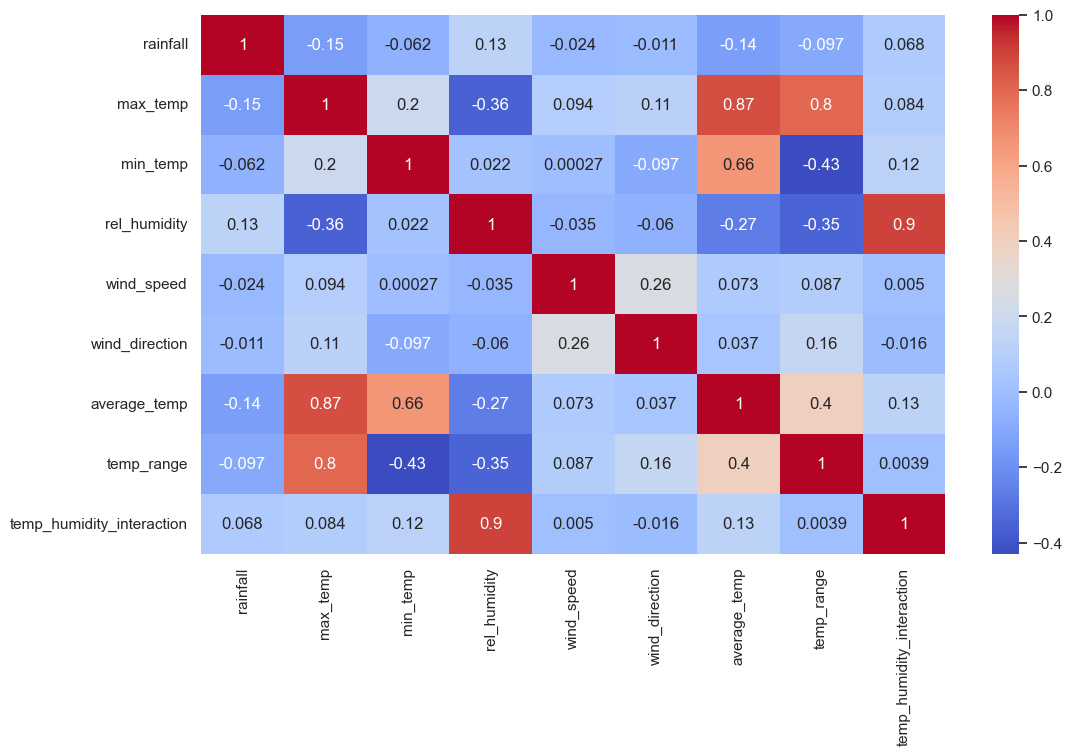

In [18]:
plt.figure(figsize=(12,7))
sns.heatmap(df.corr(),annot=True,cmap='coolwarm')

<AxesSubplot:xlabel='max_temp'>

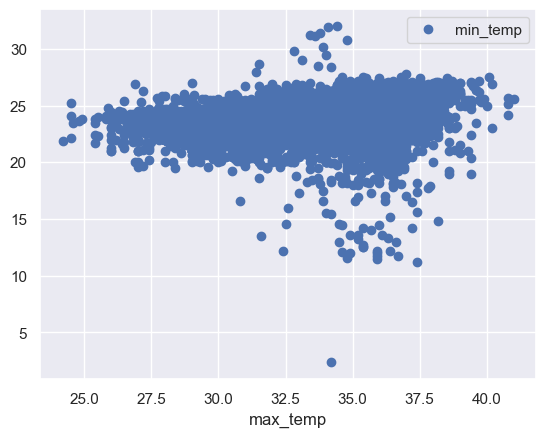

In [19]:
df.plot("max_temp","min_temp",style='o') 

In [20]:
df

,date,rainfall,max_temp,min_temp,rel_humidity,wind_speed,wind_direction,average_temp,rainfall_level,temp_range,temp_humidity_interaction
0,2006-01-01,0.0,35.0,25.0,71,0,180,30.00,No Rain,10.0,2485.0
1,2006-01-02,0.0,35.0,25.0,64,6,270,30.00,No Rain,10.0,2240.0
2,2006-01-03,0.0,35.0,25.0,68,5,220,30.00,No Rain,10.0,2380.0
3,2006-01-04,0.0,35.0,25.0,76,12,220,30.00,No Rain,10.0,2660.0
4,2006-01-05,0.0,34.0,23.0,71,5,290,28.50,No Rain,11.0,2414.0
...,...,...,...,...,...,...,...,...,...,...,...
5456,2020-12-27,0.0,35.8,23.6,69,3,133,29.70,No Rain,12.2,2470.2
5457,2020-12-28,0.0,36.6,18.2,67,5,112,27.40,No Rain,18.4,2452.2
5458,2020-12-29,0.0,36.5,19.0,67,3,81,27.75,No Rain,17.5,2445.5
5459,2020-12-30,0.0,35.1,20.2,68,4,78,27.65,No Rain,14.9,2386.8


### Data Preprocessing

In [21]:
df=df.drop(["date"],axis=1)

**Remove Outliers & Infinite Values**

Since this dataset may contain ***Outliers, it will be removed***, to make data set more even.

In [22]:
numerical_columns = df.select_dtypes(include=np.number)

# Calculate the z-scores for each numerical column
z_scores = numerical_columns.apply(zscore)

# Set the threshold for outlier detection
threshold = 3

# Create a boolean mask to identify outliers
outlier_mask = (z_scores.abs() > threshold).any(axis=1)

# Filter out the rows that contain outliers
df = df[~outlier_mask]

In [23]:
df.head()

,rainfall,max_temp,min_temp,rel_humidity,wind_speed,wind_direction,average_temp,rainfall_level,temp_range,temp_humidity_interaction
0,0.0,35.0,25.0,71,0,180,30.0,No Rain,10.0,2485.0
1,0.0,35.0,25.0,64,6,270,30.0,No Rain,10.0,2240.0
2,0.0,35.0,25.0,68,5,220,30.0,No Rain,10.0,2380.0
4,0.0,34.0,23.0,71,5,290,28.5,No Rain,11.0,2414.0
5,0.0,35.0,25.0,43,4,270,30.0,No Rain,10.0,1505.0


In [24]:
# Calculate the skewness of the "rainfall" column
rainfall_skewness = skew(df["rainfall"])

print("Skewness of rainfall column:", rainfall_skewness)


Skewness of rainfall column: 3.3228849122198687


The rainfall column has a positive skewness value of 3.33, indicating a right-skewed distribution. This means that most of the rainfall values are concentrated towards lower amounts, with a few instances of very high rainfall values contributing to a long tail on the right side of the distribution.

In [25]:
df.head()

,rainfall,max_temp,min_temp,rel_humidity,wind_speed,wind_direction,average_temp,rainfall_level,temp_range,temp_humidity_interaction
0,0.0,35.0,25.0,71,0,180,30.0,No Rain,10.0,2485.0
1,0.0,35.0,25.0,64,6,270,30.0,No Rain,10.0,2240.0
2,0.0,35.0,25.0,68,5,220,30.0,No Rain,10.0,2380.0
4,0.0,34.0,23.0,71,5,290,28.5,No Rain,11.0,2414.0
5,0.0,35.0,25.0,43,4,270,30.0,No Rain,10.0,1505.0


#### Feature Engineering

In [26]:
X = df.drop(['rainfall','rainfall_level'], axis=1)
y = df['rainfall']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [27]:
selector = SelectKBest(score_func=chi2, k=4)
X_new = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]

print(f"Selected Features: {selected_features}")

Selected Features: Index(['rel_humidity', 'wind_speed', 'wind_direction',
       'temp_humidity_interaction'],
      dtype='object')


In [28]:
model = RandomForestClassifier()


model.fit(X, y)

importances = model.feature_importances_

for feature, importance in zip(X.columns, importances):
    print(f"{feature}: {importance}")

max_temp: 0.1306881906250089
min_temp: 0.12221458386095534
rel_humidity: 0.11988380164300559
wind_speed: 0.0919659369056616
wind_direction: 0.1105020105137957
average_temp: 0.1373328628943371
temp_range: 0.13243200670323382
temp_humidity_interaction: 0.1549806068540019


From the Feature Importance we get to see that:
- max_temp: This feature has an importance score of 0.1328. It suggests that the maximum temperature has a moderate influence on the classification outcome.
- min_temp: This feature has an importance score of 0.1222. It indicates that the minimum temperature also has a moderate impact on the classification.
- rel_humidity: This feature has an importance score of 0.1189. It implies that relative humidity plays a significant role in the classification process.
- wind_speed: This feature has an importance score of 0.0909. It suggests that wind speed has a relatively lower impact on the classification compared to other variables.
- wind_direction: This feature has an importance score of 0.1078. It indicates that wind direction has a moderate influence on the classification outcome.
- average_temp: This feature has an importance score of 0.1378. It suggests that the average temperature has a relatively higher impact on the classification.
- temp_range: This feature has an importance score of 0.1352. It implies that the temperature range (difference between max and min temp) is an important factor for the classification.
- temp_humidity_interaction: This feature has the highest importance score of 0.1543. It suggests that the interaction between temperature and humidity is a crucial aspect in the classification process.

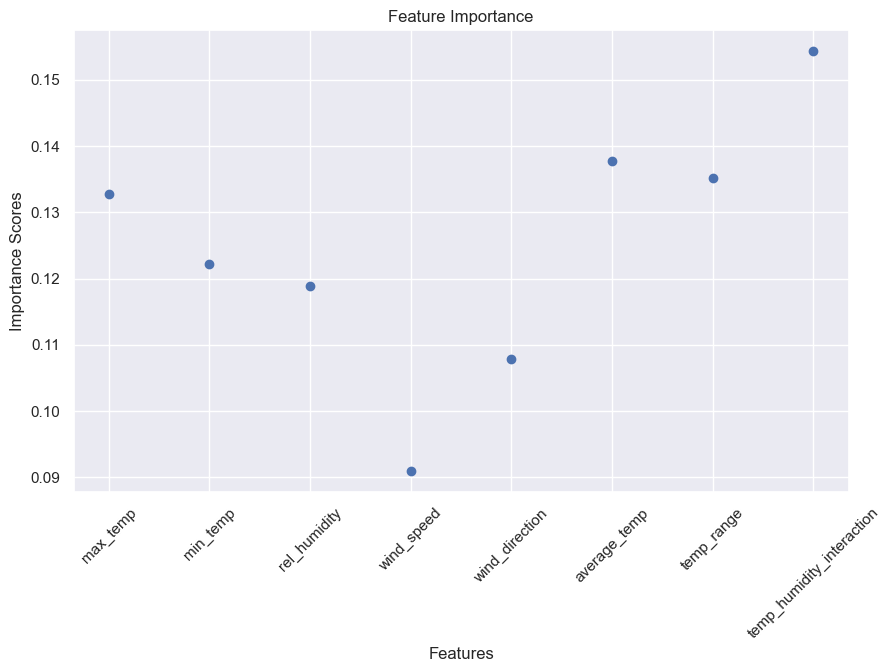

In [29]:
features = ['max_temp', 'min_temp', 'rel_humidity', 'wind_speed', 'wind_direction', 'average_temp', 'temp_range', 'temp_humidity_interaction']
importance_scores = [0.1328, 0.1222, 0.1189, 0.0909, 0.1078, 0.1378, 0.1352, 0.1543]

# Creating a scatter plot to visualize the feature importance
plt.figure(figsize=(10, 6))
plt.scatter(features, importance_scores)
plt.xlabel('Features')
plt.ylabel('Importance Scores')
plt.title('Feature Importance')
plt.xticks(rotation=45)
plt.show()


The least important features will be removed and the top four features selected

### Splitting Data

In [30]:
X = df[['max_temp', 'average_temp', 'temp_range','temp_humidity_interaction']]
y = df['rainfall_level']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
numeric_features = df.select_dtypes(include=np.number)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_features)

scaled_weather = pd.DataFrame(scaled_data, columns=numeric_features.columns)

preprocessed_data = pd.concat([scaled_weather, df[selected_features]], axis=1)

### Classification model this time

In [33]:
# Logistic Regression
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)
logreg_predictions = logreg_model.predict(X_test)
logreg_accuracy = accuracy_score(y_test, logreg_predictions)
print("Logistic Regression Accuracy:", logreg_accuracy * 100)

# K-Nearest Neighbors
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
knn_predictions = knn_model.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_predictions)
print("K-Nearest Neighbors Accuracy:", knn_accuracy * 100)

# Support Vector Classifier
svc_model = SVC()
svc_model.fit(X_train, y_train)
svc_predictions = svc_model.predict(X_test)
svc_accuracy = accuracy_score(y_test, svc_predictions)
print("Support Vector Classifier Accuracy:", svc_accuracy * 100)

# Gradient Boosting Classifier
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)
gb_predictions = gb_model.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_predictions)
print("Gradient Boosting Classifier Accuracy:", gb_accuracy * 100)


Logistic Regression Accuracy: 72.42718446601941
K-Nearest Neighbors Accuracy: 68.44660194174757
Support Vector Classifier Accuracy: 70.67961165048544
Gradient Boosting Classifier Accuracy: 71.16504854368932


- Logistic Regression Accuracy: 72.42%
This indicates that the Logistic Regression model achieved an accuracy of 72.42%. It correctly classified 72.42 of the samples in the test set.

- K-Nearest Neighbors Accuracy: 68.44%
The K-Nearest Neighbors model achieved an accuracy of 68.44%. It correctly classified 68.44% of the samples in the test set.

- Support Vector Classifier Accuracy: 70.68%
The Support Vector Classifier model achieved an accuracy of 70.68%. It correctly classified 70.68% of the samples in the test set.

- Gradient Boosting Classifier Accuracy: 71.16%
The Gradient Boosting Classifier model achieved an accuracy of 71.16%. It correctly classified 71.16% of the samples in the test set.

These accuracy scores provide a measure of how well each model performed in predicting the target variable.

Overall, the logistic regression, gradient boosting classifier, and random forest regression models tend to perform better than the decision tree regression and support vector classifier models. 

## Checking overfitting in all the models

In [34]:
models = [logreg_model, knn_model, svc_model,gb_model]


for model in models:
    model.fit(X_train, y_train)
    
    train_predictions = model.predict(X_train)
    train_score = accuracy_score(y_train, train_predictions)
    
    test_predictions = model.predict(X_test)
    test_score = accuracy_score(y_test, test_predictions)
    
    print("Model:", model)
    print("Training score:", train_score)
    print("Testing score:", test_score)
    print()


Model: LogisticRegression()
Training score: 0.7319737800437
Testing score: 0.7242718446601941

Model: KNeighborsClassifier()
Training score: 0.7912114590920126
Testing score: 0.6844660194174758

Model: SVC()
Training score: 0.7147365865501335
Testing score: 0.7067961165048544

Model: GradientBoostingClassifier()
Training score: 0.7676620538965768
Testing score: 0.7116504854368932



The results show the training and testing scores for each model. The training score represents the accuracy of the model on the training data, while the testing score represents the accuracy on the unseen testing data.

- LogisticRegression: The model achieved a training score of 0.7319 and a testing score of 0.7243. This suggests that the model is performing consistently on both the training and testing data.

- KNeighborsClassifier: The model achieved a higher training score of 0.7912 but a lower testing score of 0.6845. This indicates that the model is likely overfitting the training data and not generalizing well to unseen data.

- SVC (Support Vector Classifier): The model achieved a training score of 0.7147 and a testing score of 0.7068. The scores are relatively close, suggesting that the model is performing consistently and not showing significant overfitting or underfitting.

- GradientBoostingClassifier: The model achieved a training score of 0.7677 and a testing score of 0.7117. Similar to the logistic regression model, the scores are relatively close, indicating good generalization performance.

Overall, it appears that the logistic regression and gradient boosting classifier models performed relatively well with balanced training and testing scores. The KNeighborsClassifier model may be overfitting the training data, while the SVC model shows decent performance but could potentially be further optimized.

### Testing with new data

#### Classification Model

Since the LogisticRegression performs better in the classification model, we will be testing the new data using the LogisticRegression.

In [35]:
input=[[24,15,10,112]]
cla=logreg_model.predict(input)
print("The weather is:", cla)

The weather is: ['No Rain']


The model predicted 'No Rain' meaning from the data inputed into the model there will be no rainfall.